In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import itertools


In [16]:

# --- 1. CONFIGURATION ---
class Config:
    """Configuration settings for analysis."""
    DATA_ROOT = './MNIST-Data'
    MODEL_LOAD_PATH = 'best_mnist_cnn.pth'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 128 
    NUM_CLASSES = 10
    ERROR_SAMPLE_COUNT = 5 # Number of examples to show for the most confused pair



In [22]:

# --- 2. MODEL DEFINITION (Must match the trained model exactly) ---
class SimpleCNN(nn.Module):
    """The exact CNN architecture used for training the model."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 125)
        self.fc2 = nn.Linear(125, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7) 
        x = self.fc1(x)
        x = self.fc2(x)
        return x



In [23]:

# --- 3. DATA LOADING & TRANSFORMS ---
def load_data():
    """Loads and returns the test DataLoader and the raw test dataset."""
    # Transform for model input (Normalization is crucial)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) 
    ])
    
    # Load dataset for model input
    test_dataset = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transform)
    test_loader = DataLoader(dataset=test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    
    # Load raw dataset for visualization (no normalization)
    test_dataset_raw = MNIST(root=Config.DATA_ROOT, train=False, download=True, transform=transforms.ToTensor())
    
    return test_loader, test_dataset_raw


In [24]:

# --- 4. MODEL LOADING AND PREDICTION FUNCTION ---
def load_and_predict(test_loader, device):
    """Loads the model, runs predictions on the entire test set, and collects data."""
    
    # Initialize Model
    model = SimpleCNN().to(device)
    if not os.path.exists(Config.MODEL_LOAD_PATH):
        print(f"Error: Model file not found at {Config.MODEL_LOAD_PATH}.")
        return None, None
    
    # Load the saved state dictionary
    model.load_state_dict(torch.load(Config.MODEL_LOAD_PATH, map_location=device))
    model.eval()
    print(f"Model successfully loaded from {Config.MODEL_LOAD_PATH}.")

    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(pred.cpu().numpy())

    return np.array(all_targets), np.array(all_predictions)


In [25]:

# --- 5. VISUALIZATION FUNCTIONS ---

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Plots the confusion matrix using matplotlib."""
    
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Use white text if the color is dark, otherwise black
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def visualize_errors(targets, predictions, dataset_raw, error_count):
    """Identifies and visualizes the most confused pair of digits."""
    
    # 1. Calculate the Confusion Matrix
    cm = confusion_matrix(targets, predictions)
    
    # Set correct predictions (diagonal) to zero to focus on errors
    np.fill_diagonal(cm, 0)
    
    # 2. Find the index of the largest off-diagonal element (most confused pair)
    # The max value will be the number of times True Label=i was predicted as Pred Label=j
    flat_index = np.argmax(cm)
    true_label_confused = flat_index // Config.NUM_CLASSES
    pred_label_confused = flat_index % Config.NUM_CLASSES
    
    print(f"\n--- Error Analysis ---")
    print(f"Most Confused Pair: True label '{true_label_confused}' was misclassified as '{pred_label_confused}' {cm[true_label_confused, pred_label_confused]} times.")

    # 3. Find indices where this specific error occurred
    error_indices = np.where((targets == true_label_confused) & (predictions == pred_label_confused))[0]
    
    # Sample the first few errors
    sample_indices = error_indices[:error_count]
    
    # 4. Plot the misclassified samples
    plt.figure(figsize=(12, 2))
    plt.suptitle(f"Samples of True '{true_label_confused}' Misclassified as '{pred_label_confused}'", fontsize=14)

    for i, data_index in enumerate(sample_indices):
        # Retrieve the image using the index from the raw dataset
        image_tensor, _ = dataset_raw[data_index] 
        image_np = image_tensor.squeeze().numpy() 

        ax = plt.subplot(1, error_count, i + 1)
        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Index: {data_index}", fontsize=8)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



Starting Model Analysis...
Model successfully loaded from best_mnist_cnn.pth.


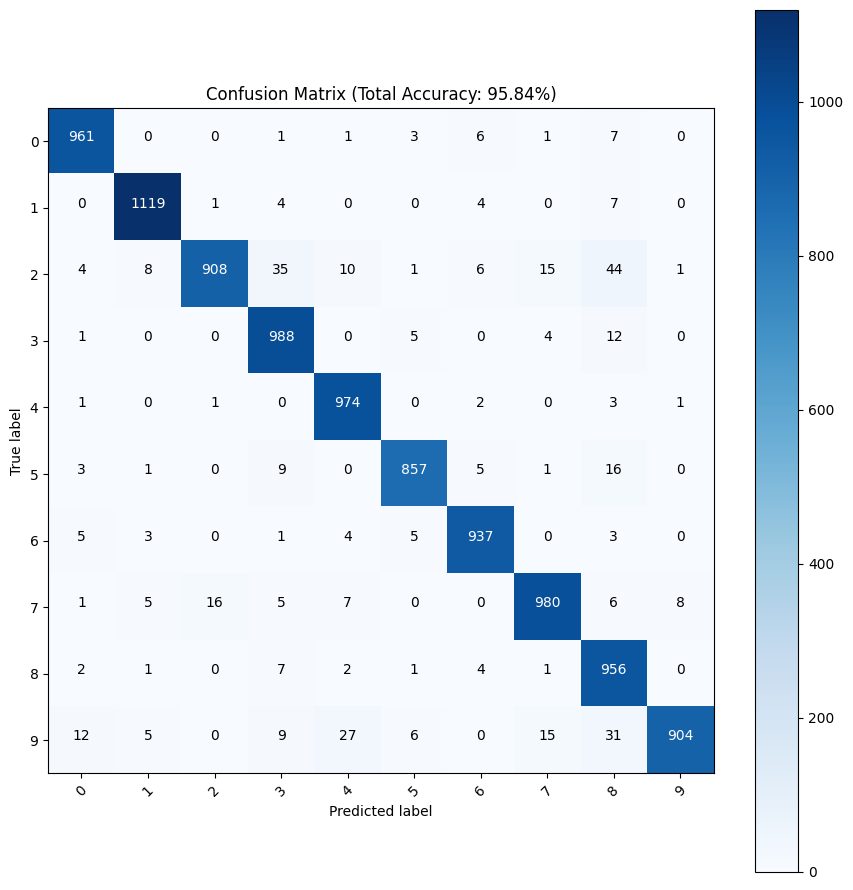


--- Error Analysis ---
Most Confused Pair: True label '2' was misclassified as '8' 44 times.


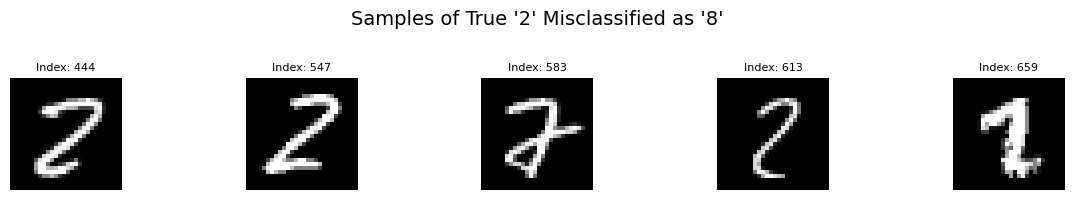

In [26]:

# --- 6. MAIN EXECUTION ---
if __name__ == '__main__':
    print("Starting Model Analysis...")
    
    # Load Data
    test_loader, test_dataset_raw = load_data()
    
    # Run Predictions
    targets, predictions = load_and_predict(test_loader, Config.DEVICE)

    if targets is None:
        print("Analysis failed due to missing model file. Please run training script first.")
    else:
        # Calculate and Plot Confusion Matrix
        cm = confusion_matrix(targets, predictions)
        plot_confusion_matrix(cm, classes=list(range(Config.NUM_CLASSES)), 
                              title=f'Confusion Matrix (Total Accuracy: {np.mean(targets == predictions)*100:.2f}%)')
        
        # Visualize the most frequently misclassified digits
        visualize_errors(targets, predictions, test_dataset_raw, Config.ERROR_SAMPLE_COUNT)